In [1]:
import jax
import jax.numpy as jnp
import jax.random as random

import jax_cosmo as jc

import numpyro
from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer import init_to_value, Trace_ELBO, SVI
from optax import adam

import matplotlib.pyplot as plt

import arviz as az;

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
key = random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = random.split(key, 4)

## Creating some data

In [129]:
shape = (2000,)
z_random = random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)

In [130]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

In [131]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2)/h
    dist_mod = 25 + 5 * jnp.log10(dist_L)
    return dist_mod

In [132]:
sigma = 0.1 * jnp.log(1+z)
dist_mod_err = sigma * random.uniform(subkey, shape, minval=-1, maxval=1) 

cov = jnp.diag(sigma)

In [133]:
dist_mod = distance_modulus(true_param, z) + dist_mod_err

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


Text(0, 0.5, 'distance modulus')

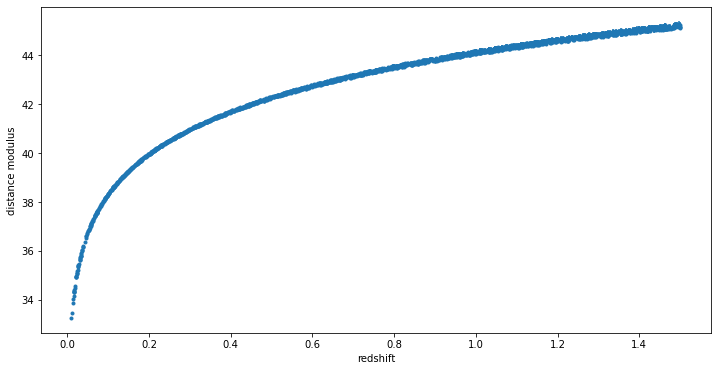

In [134]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.xlabel('redshift')
plt.ylabel('distance modulus')

## Setting up the model

In [135]:
def model_cpl(x, y, cov):
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w0 = sample("w0", dist.Uniform(-10, 10))
    wa = sample("wa", dist.Uniform(-10,10))
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, x)
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

## Running the optimizer

In [136]:
initial_values = {'Omega_m':0.5, 'w0':-1., 'wa':0.}

In [137]:
guide_cpl = AutoMultivariateNormal(model_cpl, 
                                   init_loc_fn = init_to_value(values=initial_values))

In [138]:
svi = SVI(model_cpl, 
    guide_cpl, 
    adam(0.0001), 
    Trace_ELBO(),     
    x = z,
    y = dist_mod,
    cov = cov
)

In [139]:
svi_result = svi.run(subkey2, 30000)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|██████████████████| 30000/30000 [31:22<00:00, 15.94it/s, init loss: 38.7252, avg. loss [28501-30000]: -1270.2460]


In [140]:
samples = guide_cpl.sample_posterior(subkey3, svi_result.params, (100000,))
idata = az.from_dict(samples)

In [141]:
az.summary(idata, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Omega_m,0.402,0.014,0.377,0.429
w0,-1.157,0.165,-1.462,-0.845
wa,-2.618,1.030,-4.511,-0.663


array([[<AxesSubplot:ylabel='$\\Omega_{m,0}$'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$w_0$'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\Omega_{m,0}$', ylabel='$w_a$'>,
        <AxesSubplot:xlabel='$w_0$'>, <AxesSubplot:xlabel='$w_a$'>]],
      dtype=object)

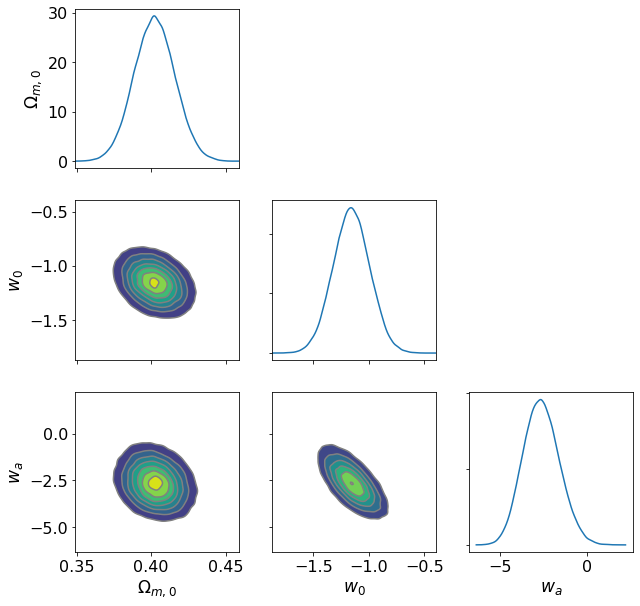

In [142]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
               "w0" :  r"$w_0$",
               "wa" : r"$w_a$"}   

labeller = az.labels.MapLabeller(var_name_map=var_dict)

az.plot_pair(idata, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller)

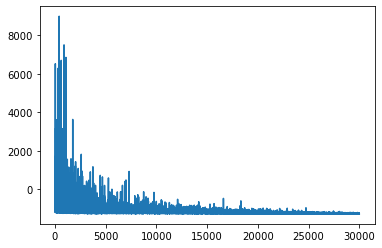

In [143]:
plt.plot(svi_result.losses)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


Text(0, 0.5, 'distance modulus')

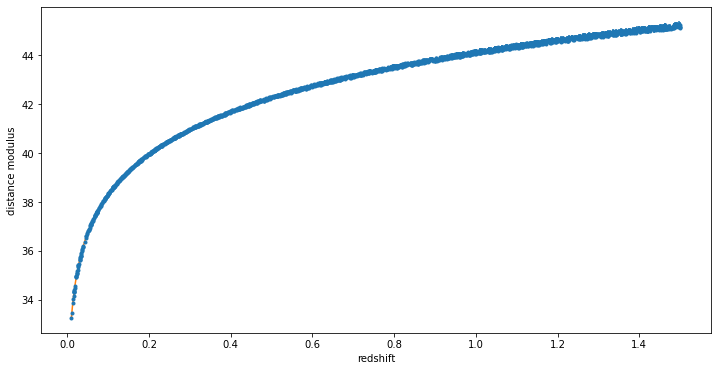

In [144]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.plot(z, distance_modulus({'Omega_m':0.385, 'w0':-0.993, 'wa':-3.02}, z))
plt.xlabel('redshift')
plt.ylabel('distance modulus')